### ISSM CA3
Name: Ng Boon Cheong Raymond  
Student ID: A0198543R

In [99]:
import numpy as np
import pandas as pd
import pydot
import IPython
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time

from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### Dataset attributes
Column 1: Timestamp in seconds  
Column 2: Timestamp in microseconds  
Column 3-15: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S1 (Left Calf)  
Column 16-28: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S2 (Left Thigh)  
Column 29-41: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S3 (Right Calf)  
Column 42-54: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S4 (Right Thigh)  
Column 55-67: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S5 (Back)  
Column 68-80: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S6 (Left Lower Arm)  
Column 81-93: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S7 (Left Upper Arm)  
Column 94-106: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S8 (Right Lower Arm)  
Column 107-119: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S9 (Right Upper Arm)  
Column 120: Label (see activity set) [Walking = 1] [Jogging = 2] [Running = 3]

### Dataset attribute subset to be used
Col[0]: Timestamp in seconds  
Col[1]: Timestamp in microseconds  
Col[67-69]: Accel Sensor S6  
Col[70-72]: Gyro Sensor S6  
Col[76-79]: Quart Sensor S6  
Col[93-95]: Accel Sensor S8  
Col[96-98]: Gyro Sensor S8  
Col[102-105]: Quart Sensor S8  
Col[119]: Activity Label

In [100]:
def readLog(file):
    """Read a single file and return 3 dataframe, for walking, jogging and running"""
    df = pd.read_csv(file, header=None, delim_whitespace=True)
    df_walk = df[df[119] == 1]
    df_jog = df[df[119] == 2]
    df_run = df[df[119] == 3]
    return df_walk, df_jog, df_run

In [101]:
def removeOtherSensor(df_walk, df_jog, df_run):
    # [3:67] S1 to S5
    # [73:76] Mag sensor for S6
    # [80:93] S7
    # [99:102] Mag sensor for S8
    # [106:119] S9
    """Remove all other sensors other than S6 and S8, also removed mag sensors"""
    idx = np.r_[2:67, 73:76, 80:93, 99:102, 106:119]
    return df_walk.drop(df_walk.columns[idx], axis=1), df_jog.drop(df_jog.columns[idx], axis=1), df_run.drop(df_run.columns[idx], axis=1)

In [102]:
def resetIndex(df_walk, df_jog, df_run):
    """Drop the index column created by reset_index()"""
    return df_walk.reset_index().drop('index', axis=1), df_jog.reset_index().drop('index', axis=1), df_run.reset_index().drop('index', axis=1)

In [103]:
def trimForCompleteSeconds(df):
    """Trim the dataframe so that only complete seconds is retained, each row is 0.02 seconds window"""
    rIdxDrop = []
    # This will trim the first few row of incomplete microseconds
    for i in range(len(df[1])):
        if df[1][i] != 0.0:
            rIdxDrop.append(i)
        else:
            break
    # This will trim the last few row of imcomplete microseconds
    for i in reversed(range(len(df[1]))):
        if df[1][i] != 980000.0:
            rIdxDrop.append(i)
        else:
            break
    return df.drop(rIdxDrop, axis=0)

In [104]:
def splitSensor(df):
    """Split an activity dataframe into 3 sensor type, accel, gryo and quart"""
    # index for accel sensor for S6 and S8
    idx_accel = [67, 68, 69, 93, 94, 95]
    # index for gryo sensor for S6 and S8
    idx_gyro = [70, 71, 72, 96, 97, 98]
    # index for quart sensor for S6 and S8
    idx_quart = [76, 77, 78, 79, 102, 103, 104, 105]
    return df[idx_accel], df[idx_gyro], df[idx_quart]

In [106]:
def createWindowWithDistance(df, timestep=50, distance=20):
    """Split sensor data into windows of timestep size (timestep (in 0.02 microseconds) : 50 = 1 sec) and overlapped with a distance value"""
    win_stack = []
    for i in range(0, len(df), distance):
        try:
            window = []
            for t in range(timestep):
                window.append(df[i+t])
            win_stack.append(window)
        except:
            continue # Drop any data row which does not fit into the requested time step
    return np.array(win_stack)

In [107]:
def makeDataset():
    """Make a dataset split into walk, jog, run activity with all sensors"""
    dataset_dir = '..\dataset'
    files = glob.glob(dataset_dir + '\*.log')
    dfWalk = []
    dfJog = []
    dfRun = []
    for file in files:
        walk, jog, run = readLog(file)
        dfw, dfj, dfr = removeOtherSensor(walk, jog, run)
        dfw, dfj, dfr = resetIndex(dfw, dfj, dfr)
#         dfw = trimForCompleteSeconds(dfw)
#         dfj = trimForCompleteSeconds(dfj)
#         dfr = trimForCompleteSeconds(dfr)
        dfWalk.append(dfw)
        dfJog.append(dfj)
        dfRun.append(dfr)
    return pd.concat(dfWalk, ignore_index=True), pd.concat(dfJog, ignore_index=True), pd.concat(dfRun, ignore_index=True)

In [108]:
def makeSensorDataSet(df):
    """Make a secondary dataset from a single activity dataset"""
    accel, gyro, quart = splitSensor(df)
    accel, gyro, quart = resetIndex(accel, gyro, quart)
    return accel, gyro, quart

In [109]:
def makeAllSensorWindowedDataSet(accel, gyro, quart, timestep=50, distance=20):
    """Spilt into a windowed dataset. Format = [sample, timestep, features]"""
    stack = []
    for aCol in accel:
        stack.append(createWindowWithDistance(accel[aCol], timestep, distance))
    for gCol in gyro:
        stack.append(createWindowWithDistance(gyro[gCol], timestep, distance))
    for qCol in quart:
        stack.append(createWindowWithDistance(quart[qCol], timestep, distance))
    return np.dstack(stack)    

In [110]:
def makeSingleSensorWindowedDataSet(sensor, timestep=50, distance=20):
    """Spilt into a windowed dataset. Format = [sample, timestep, features]"""
    stack = []
    for col in sensor:
        stack.append(createWindowWithDistance(sensor[col], timestep, distance))
    return np.dstack(stack)

### Create base sensor dataset

In [111]:
%%time
walk, jog, run = makeDataset()

Wall time: 59.2 s


In [112]:
%%time
accel, gyro, quart = makeSensorDataSet(run)

Wall time: 48.4 ms


### Apply standardscaler to dataset

In [113]:
standscale = StandardScaler()
accelS = pd.DataFrame(
    data=standscale.fit_transform(accel),
    columns=accel.columns)
gyroS = pd.DataFrame(
    data=standscale.fit_transform(gyro),
    columns=gyro.columns)
quartS = pd.DataFrame(
    data=standscale.fit_transform(quart),
    columns=quart.columns)

In [114]:
accelS.head()

,67,68,69,93,94,95
0,0.776105,-0.247185,1.584141,0.041589,-0.897530,-0.379342
1,1.206023,-0.234152,1.892669,-0.478163,-0.373689,-0.617084
2,1.322472,-0.055012,1.646331,-1.132766,-0.220623,-0.463028
3,1.239124,0.165607,1.194642,-0.825498,-0.009890,-0.143038
4,1.255853,0.293037,0.934439,-0.606731,-0.097947,-0.090501


In [115]:
gyroS.head()

,70,71,72,96,97,98
0,-0.926166,-0.143446,0.358982,0.132815,0.572588,0.447733
1,-0.397393,0.342576,0.171727,0.651977,1.008271,1.051742
2,-0.747756,0.938283,-0.045250,0.818545,0.910221,0.933855
3,-0.707018,1.409877,-0.015109,0.578459,1.306300,0.590498
4,-0.662708,1.635903,0.077873,0.331479,1.428992,-0.066984


In [116]:
quartS.head()

,76,77,78,79,102,103,104,105
0,0.030646,0.979435,0.255913,-2.706804,-1.771026,1.213646,-1.052901,-0.153185
1,0.043992,1.015599,0.261471,-2.701292,-1.739483,1.168043,-1.089686,-0.136152
2,0.048282,1.109491,0.273579,-2.678926,-1.711128,1.113498,-1.122895,-0.110539
3,0.052935,1.246420,0.279474,-2.638388,-1.668026,1.088432,-1.164709,-0.081429
4,0.062128,1.401169,0.281463,-2.581260,-1.619705,1.095850,-1.205837,-0.047462


### Create windowed dataset

In [117]:
accelW = makeSingleSensorWindowedDataSet(accelS, 50, 20)
gyroW = makeSingleSensorWindowedDataSet(gyroS, 50, 20)
quartW = makeSingleSensorWindowedDataSet(quartS, 50, 20)

accel_train_size = np.int(len(accelW) * 0.8)
gyro_train_size = np.int(len(gyroW) * 0.8)
quart_train_size = np.int(len(quartW) * 0.8)

In [118]:
train_accel, test_accel = accelW[:accel_train_size,:,:], accelW[accel_train_size:]
train_gyro, test_gyro = gyroW[:gyro_train_size,:,:], gyroW[gyro_train_size:]
train_quart, test_quart = quartW[:quart_train_size,:,:], quartW[quart_train_size:]

In [119]:
print(f'Train Accel: {train_accel.shape}, Test Accel: {test_accel.shape}')
print(f'Train Accel: {train_gyro.shape}, Test Accel: {test_gyro.shape}')
print(f'Train Accel: {train_quart.shape}, Test Accel: {test_quart.shape}')

Train Accel: (1399, 50, 6), Test Accel: (350, 50, 6)
Train Accel: (1399, 50, 6), Test Accel: (350, 50, 6)
Train Accel: (1399, 50, 8), Test Accel: (350, 50, 8)


In [120]:
seed = 42
np.random.seed(seed)

In [121]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)
]

### Base Model (Accel only)

In [122]:
# Config
encoder_dimension = 42
EPOCH = 100
BATCH_SIZE = 24

In [123]:
def build_base_model(train_accel):
    # Input dimension
    input_accel = Input(shape=(train_accel.shape[1],train_accel.shape[2]), name='Input_Accel')
    # Encoder
    encoder = Dense(50, activation='relu', name='Encoder1')(input_accel)
    encoder = Dense(25, activation='relu', name='Encoder2')(encoder)
    # Hidden
    hidden = Dense(5, activation='relu', name='Hidden')(encoder)
    # Decoder
    decoder = Dense(25, activation='relu', name='Decoder1')(hidden)
    decoder = Dense(50, activation='relu', name='Decoder2')(decoder)
    output = Dense(6, activation='relu', name='Output')(decoder)
    model = Model(inputs=input_accel, output=output)
    return model

In [124]:
bmodel = build_base_model(train_accel)
bmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Accel (InputLayer)     (None, 50, 6)             0         
_________________________________________________________________
Encoder1 (Dense)             (None, 50, 50)            350       
_________________________________________________________________
Encoder2 (Dense)             (None, 50, 25)            1275      
_________________________________________________________________
Hidden (Dense)               (None, 50, 5)             130       
_________________________________________________________________
Decoder1 (Dense)             (None, 50, 25)            150       
_________________________________________________________________
Decoder2 (Dense)             (None, 50, 50)            1300      
_________________________________________________________________
Output (Dense)               (None, 50, 6)             306       
Total para

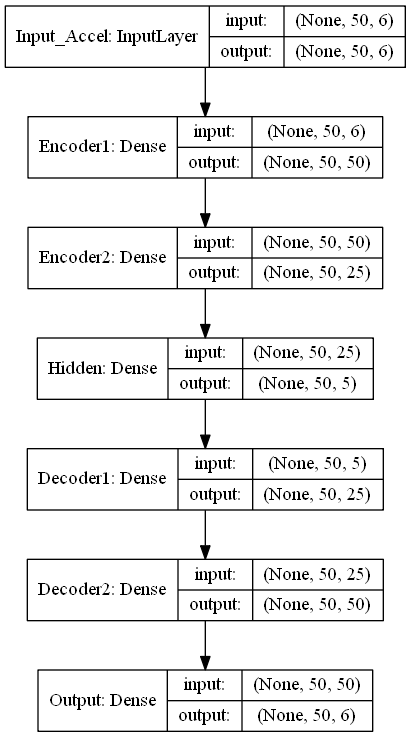

In [125]:
plot_model(bmodel, 
           to_file='modelb.png', 
           show_shapes=True,
           show_layer_names=True)
IPython.display.Image('modelb.png')

In [126]:
bmodel.compile(optimizer='adam', metrics=['accuracy'], loss=['mean_squared_error'])

In [127]:
%%time
bhistory = bmodel.fit(train_accel, train_accel, 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks)

Train on 1259 samples, validate on 140 samples
Epoch 1/100
1259/1259 [==============================] - 2s 1ms/step - loss: 0.9534 - acc: 0.3661 - val_loss: 0.8345 - val_acc: 0.5760
Epoch 2/100
1259/1259 [==============================] - 1s 426us/step - loss: 0.7052 - acc: 0.6315 - val_loss: 0.6866 - val_acc: 0.7269
Epoch 3/100
1259/1259 [==============================] - 0s 381us/step - loss: 0.5946 - acc: 0.8071 - val_loss: 0.6501 - val_acc: 0.8047
Epoch 4/100
1259/1259 [==============================] - 1s 415us/step - loss: 0.5716 - acc: 0.8647 - val_loss: 0.6340 - val_acc: 0.8494
Epoch 5/100
1259/1259 [==============================] - 1s 499us/step - loss: 0.5530 - acc: 0.8918 - val_loss: 0.6215 - val_acc: 0.8684
Epoch 6/100
1259/1259 [==============================] - 1s 402us/step - loss: 0.5357 - acc: 0.9120 - val_loss: 0.6113 - val_acc: 0.8984
Epoch 7/100
1259/1259 [==============================] - 1s 427us/step - loss: 0.5301 - acc: 0.9239 - val_loss: 0.6099 - val_acc: 0.9

In [134]:
score, acc = bmodel.evaluate(test_accel, test_accel, batch_size=BATCH_SIZE)
print(f'Test Score: {score}')
print(f'Test Acc: {acc}')

350/350 [==============================] - 0s 964us/step
Test Score: 0.44245660066604614
Test Acc: 0.9601142730031694


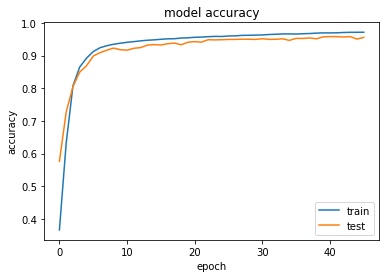

In [142]:
# summarize history for accuracy
plt.plot(bhistory.history['acc'])
plt.plot(bhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

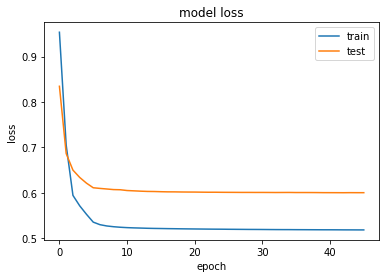

In [143]:
# summarize history for loss
plt.plot(bhistory.history['loss'])
plt.plot(bhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [137]:
test_predict = bmodel.predict(test_accel[0])
testScores = metrics.accuracy_score(test_accel, test_predict.round())

ValueError: Error when checking input: expected Input_Accel to have 3 dimensions, but got array with shape (50, 6)

In [132]:
mse = np.mean(np.power(test_accel - test_predict, 2), keepdims=True)
# testScore = metrics.accuracy_score(test_accel, test_predict.round())
tc = np.mean(np.power(test_accel,2), axis=1)
# print(len(mse))

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': })
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df.Reconstruction_error, error_df.True_class)

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-132-b435fad25c4e>, line 7)

### Multi Sensor input / autoencoder / single output model

In [ ]:
# Config
encoder_dimension = 42
EPOCH = 100
BATCH_SIZE = 24

In [ ]:
def build_multi_in_single_out_model(train_accel, train_gyro, train_quart):
    # All input
    input_accel = Input(shape=(train_accel.shape[1], train_accel.shape[2]), name='Input_Accel')
    input_gyro = Input(shape=(train_gyro.shape[1], train_gyro.shape[2]), name='Input_Gyro')
    input_quart = Input(shape=(train_quart.shape[1], train_quart.shape[2]), name='Input_Quart')
    # Encoder branch for Accel
    accel_encoder = Dense(50, activation='relu', name='Encoder1_Accel')(input_accel)
    accel_encoder = Dense(25, activation='relu', name='Encoder2_Accel')(accel_encoder)
    # Encoder branch for Gyro
    gyro_encoder = Dense(50, activation='relu', name='Encoder1_Gyro')(input_gyro)
    gyro_encoder = Dense(25, activation='relu', name='Encoder2_Gyro')(gyro_encoder)
    # Encoder branch for Quart
    quart_encoder = Dense(50, activation='relu', name='Encoder1_Quart')(input_quart)
    quart_encoder = Dense(25, activation='relu', name='Encoder2_Quart')(quart_encoder)
    # Shared layer
    shared_input = Concatenate(name='Concatenate')([accel_encoder, gyro_encoder, quart_encoder])
    # Decoder
    decoder = Dense(5, activation='relu', name='Shared_Hidden_Layer')(shared_input)
    decoder = Dense(25, activation='relu', name='Decoder1')(decoder)
    decoder = Dense(50, activation='relu', name='Decoder2')(decoder)
    decoder = Dense(6, activation='relu', name='Output')(decoder)
    model = Model(inputs=([input_accel, input_gyro, input_quart]), outputs=decoder)
    return model

In [ ]:
model = build_multi_in_single_out_model(train_accel, train_gyro, train_quart)
model.summary()

In [ ]:
plot_model(model, 
           to_file='model.png', 
           show_shapes=True,
           show_layer_names=True)
IPython.display.Image('model.png')

In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss=['mean_squared_error'])

In [ ]:
%%time
history = model.fit([train_accel, train_gyro, train_quart], train_accel, 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks)

In [ ]:
test_predict = model.predict([test_accel, test_gyro, test_quart])
score, acc = model.evaluate([test_accel, test_gyro, test_quart], test_accel, batch_size=32)
print(f'Test Score: {score}')
print(f'Test Acc: {acc}')

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
threshold = 6
dist = np.linalg.norm(test_accel - test_predict, axis=1)

In [ ]:
for d in dist:
    if (d > threshold):
        print('Anomaly')

### Multi sensor input / autoencoder / multi output model

In [ ]:
# Config
encoder_dimension = 42
EPOCH = 250
BATCH_SIZE = 24

In [ ]:
def build_multi_in_multi_out_model(train_accel, train_gyro, train_quart):
    # All input
    input_accel = Input(shape=(train_accel.shape[1], train_accel.shape[2]), name='Input_Accel')
    input_gyro = Input(shape=(train_gyro.shape[1], train_gyro.shape[2]), name='Input_Gyro')
    input_quart = Input(shape=(train_quart.shape[1], train_quart.shape[2]), name='Input_Quart')
    # Encoder branch for Accel
    accel_encoder = Dense(50, activation='relu', name='Encoder1_Accel')(input_accel)
    accel_encoder = Dense(25, activation='relu', name='Encoder2_Accel')(accel_encoder)
    # Encoder branch for Gyro
    gyro_encoder = Dense(50, activation='relu', name='Encoder1_Gyro')(input_gyro)
    gyro_encoder = Dense(25, activation='relu', name='Encoder2_Gyro')(gyro_encoder)
    # Encoder branch for Quart
    quart_encoder = Dense(50, activation='relu', name='Encoder1_Quart')(input_quart)
    quart_encoder = Dense(25, activation='relu', name='Encoder2_Quart')(quart_encoder)
    # Shared layer
    shared_input = Concatenate(name='Concatenate')([accel_encoder, gyro_encoder, quart_encoder])
    shared_hidden_layer = Dense(5, activation='relu', name='Shared_Hidden_Layer')(shared_input)
    # Decoder branch for Accel    
    accel_decoder = Dense(25, activation='relu', name='Decoder1_Accel')(shared_hidden_layer)
    accel_decoder = Dense(50, activation='relu', name='Decoder2_Accel')(accel_decoder)
    accel_decoder = Dense(6, activation='relu', name='Output_Accel')(accel_decoder)
    # Decoder branch for Gyro
    gyro_decoder = Dense(25, activation='relu', name='Decoder1_Gyro')(shared_hidden_layer)
    gyro_decoder = Dense(50, activation='relu', name='Decoder2_Gyro')(gyro_decoder)
    gyro_decoder = Dense(6, activation='relu', name='Output_Gyro')(gyro_decoder)
    # Decoder branch for Quart
    quart_decoder = Dense(25, activation='relu', name='Decoder1_Quart')(shared_hidden_layer)
    quart_decoder = Dense(50, activation='relu', name='Decoder2_Quart')(quart_decoder)
    quart_decoder = Dense(8, activation='relu', name='Output_Quart')(quart_decoder)
    
    
    model = Model(inputs=([input_accel, input_gyro, input_quart]), outputs=([accel_decoder, gyro_decoder, quart_decoder]))
    return model

In [ ]:
model2 = build_multi_in_multi_out_model(train_accel, train_gyro, train_quart)
model2.summary()

In [ ]:
plot_model(model2, 
           to_file='model2.png', 
           show_shapes=True,
           show_layer_names=True)
IPython.display.Image('model2.png')

In [ ]:
model2.compile(optimizer='adam', metrics=['accuracy'], 
               loss=['mean_squared_error', 'mean_squared_error', 'mean_squared_error'])

In [ ]:
%%time
history2 = model2.fit([train_accel, train_gyro, train_quart], [train_accel, train_gyro, train_quart], 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks)

In [ ]:
test_predict2 = model2.predict([test_accel, test_gyro, test_quart])
result = model2.evaluate([test_accel, test_gyro, test_quart], [test_accel, test_gyro, test_quart], batch_size=BATCH_SIZE)
for idx in range(len(model2.metrics_names)):
    print(f'{model2.metrics_names[idx]}: {result[idx]}')

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['Output_Accel_acc'])
plt.plot(history2.history['Output_Gyro_acc'])
plt.plot(history2.history['Output_Quart_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history2.history['Output_Accel_loss'])
plt.plot(history2.history['Output_Gyro_loss'])
plt.plot(history2.history['Output_Quart_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()